[**Blueprints for Text Analysis Using Python**](https://github.com/blueprints-for-text-analytics-python/blueprints-text)  
Jens Albrecht, Sidharth Ramachandran, Christian Winkler

**If you like the book or the code examples here, please leave a friendly comment on [Amazon.com](https://www.amazon.com/Blueprints-Text-Analytics-Using-Python/dp/149207408X)!**
<img src="https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/rating.png?raw=1" width="100"/>


# Chapter 6:<div class='tocSkip'/>

# How to use classification algorithms to label text into multiple categories

## Remark<div class='tocSkip'/>

The code in this notebook differs slightly from the printed book. For example we frequently use pretty print (`pp.pprint`) instead of `print` and `tqdm`'s `progress_apply` instead of Pandas' `apply`.

Moreover, several layout and formatting commands, like `figsize` to control figure size or subplot commands are removed in the book.

You may also find some lines marked with three hashes ###. Those are not in the book as well as they don't contribute to the concept.

All of this is done to simplify the code in the book and put the focus on the important parts instead of formatting.

## Setup<div class='tocSkip'/>

Set directory locations. If working on Google Colab: copy files and install required libraries.

In [1]:
import sys, os
ON_COLAB = 'google.colab' in sys.modules

if ON_COLAB:
    GIT_ROOT = 'https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master'
    os.system(f'wget {GIT_ROOT}/ch06/setup.py')

%run -i setup.py

You are working on Google Colab.
Files will be downloaded to "/content".
!wget -P /content https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master/settings.py
!wget -P /content/data/jdt-bugs-dataset https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master/data/jdt-bugs-dataset/eclipse_jdt.csv.gz
!wget -P /content/packages/blueprints https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master/packages/blueprints/preparation.py
!wget -P /content/ch06 https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master/ch06/requirements.txt

Additional setup ...
!pip install -r ch06/requirements.txt


## Load Python Settings<div class="tocSkip"/>


In [3]:
%run "$BASE_DIR/settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'png'

# to print output of all statements and not just the last
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# otherwise text between $ signs will be interpreted as formula and printed in italic
pd.set_option('display.html.use_mathjax', False)

# path to import blueprints packages
sys.path.append(BASE_DIR + '/packages')

In [4]:
import matplotlib.pyplot as plt
import html
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
## Depracated:
# from sklearn.metrics import plot_confusion_matrix
## New version:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from blueprints.preparation import clean

## What you'll learn and what we will build

# Introducing the Java Development Tools Bug Dataset

In [6]:
file = "eclipse_jdt.csv"
file = f"{BASE_DIR}/data/jdt-bugs-dataset/eclipse_jdt.csv.gz" ### real location
df = pd.read_csv(file)

In [7]:
print (df.columns)
print(df[['Issue_id','Priority','Component','Title','Description']].sample(2, random_state=42))

Index(['Issue_id', 'Priority', 'Component', 'Duplicated_issue', 'Title',
       'Description', 'Status', 'Resolution', 'Version', 'Created_time',
       'Resolved_time'],
      dtype='object')
       Issue_id Priority Component  \
38438    239715       P3        UI   
44129    395007       P3        UI   

                                                                         Title  \
38438        No property tester for TestCaseElement for property projectNature   
44129  [package explorer] Refresh action not available on Java package folders   

                                                                                                                                                                                                   Description  
38438  I20080613-2000; ; Not sure if this belongs to JDT/Debug or Platform/Debug.; ; I saw this error message several times today in my error log but Im not yet sure how to reproduce it.; ; -- Error Deta...  
44129          M3.; ; F5 (R

In [8]:
df = df.drop(columns=['Duplicated_issue']) ###
pd.set_option('display.max_colwidth', None)
df.sample(1, random_state=123).T

,11811
Issue_id,33113
Priority,P3
Component,Debug
Title,Evaluating for loop suspends in URLClassLoader
Description,Debug to a breakpoint in some HelloWorld program. In the DisplayView; highlight and ; Display the following code snippet:; ; for (int i = 0; i < 10; i++) {; System.out.println(i);; }; ; Instead of just reporting No explicit return value; the debugger suspends in the ; URLClassLoader; apparently trying to load the class int. You have hit Resume several ; more times before the evaluation completes. The DebugView does not indicate why it ; has stopped (the thread is just labelled Evaluating). This behavior does not happen if ; you turn of the Suspend on uncaught exceptions preference.
Status,VERIFIED
Resolution,FIXED
Version,2.1
Created_time,2003-02-25 15:40:00 -0500
Resolved_time,2003-03-05 17:11:17 -0500


<Axes: xlabel='Priority'>

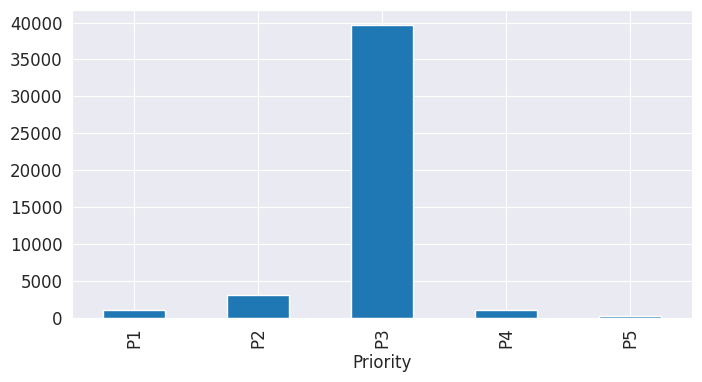

In [9]:
df['Priority'].value_counts().sort_index().plot(kind='bar')

In [10]:
df['Component'].value_counts()

,count
Component,
UI,17479
Core,13669
Debug,7542
Text,5901
APT,406
Doc,299


# Blueprint: Building a Text Classification system

## Step 1 - Data Preparation

In [11]:
df = df[['Title','Description','Priority']]
df = df.dropna()
df['text'] = df['Title'] + ' ' + df['Description']
df = df.drop(columns=['Title','Description'])
df.columns

Index(['Priority', 'text'], dtype='object')

In [12]:
# 查看一条数据
df.sample(1, random_state=123).T

,16584
Priority,P3
text,Javadoc > Project generation [javadoc] Open generated index file in browser does not take in account the -d option ; when using a custom doclet.


In [13]:
from blueprints.preparation import clean
# 使用预先定义好的clean方法预处理数据
df['text'] = df['text'].apply(clean)
df = df[df['text'].str.len() > 50]

,Priority,text
42439,P3,Regression in TypeHierarchyPerfTest#testOpenObjectHierarchy() I20110329-0800; ; http://download.eclipse.org/eclipse/downloads/drops/I20110329-0800/performance/eplnx2/Scenario415.html; ; The regression can be seen on all platforms.; ; Also TypeHierarchyPerfTest#testOpenCollHierarchy() shows erratic behavior on all platforms.
30486,P3,introduce indirection: misleading warning about duplicate method 3.2 M5 testing; ; have two classes; Foo and Bar; Foo with method m; refactor introduce indirection on m; warning: duplicate method m in declaring class (ok); change declaring class to Bar; ; the warning is still there; despite that Bar does not contain any methods; expected: the warning goes away as the declaring class is changed


In [15]:
df.sample(2, random_state=0).T

,42439,30486
Priority,P3,P3
text,Regression in TypeHierarchyPerfTest#testOpenObjectHierarchy() I20110329-0800; ; http://download.eclipse.org/eclipse/downloads/drops/I20110329-0800/performance/eplnx2/Scenario415.html; ; The regression can be seen on all platforms.; ; Also TypeHierarchyPerfTest#testOpenCollHierarchy() shows erratic behavior on all platforms.,introduce indirection: misleading warning about duplicate method 3.2 M5 testing; ; have two classes; Foo and Bar; Foo with method m; refactor introduce indirection on m; warning: duplicate method m in declaring class (ok); change declaring class to Bar; ; the warning is still there; despite that Bar does not contain any methods; expected: the warning goes away as the declaring class is changed


## Step 2 - Train-Test Split

In [18]:
X_train, X_test, \
Y_train, Y_test = train_test_split(df['text'], df['Priority'], test_size=0.2,
                                   random_state=42, stratify=df['Priority'])

print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

Size of Training Data  36040
Size of Test Data  9011


## Step 3 - Training the machine learning model

In [19]:
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)

In [20]:
model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_tf, Y_train)

LinearSVC(random_state=0, tol=1e-05)

## Step 4 - Model Evaluation

In [21]:
X_test_tf = tfidf.transform(X_test)

In [22]:
Y_pred = model1.predict(X_test_tf)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred))

Accuracy Score -  0.8761513705471091


In [23]:
clf = DummyClassifier(strategy='most_frequent', random_state=42)
clf.fit(X_train, Y_train)
Y_pred_baseline = clf.predict(X_test)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred_baseline))

DummyClassifier(random_state=42, strategy='most_frequent')

Accuracy Score -  0.8769281988680502


### Precision and Recall


In [24]:
Y_pred = model1.predict(X_test_tf)
confusion_matrix(Y_test, Y_pred)

array([[  19,    1,  199,    4,    0],
       [   6,   18,  576,    8,    0],
       [   8,   48, 7827,   19,    0],
       [   0,    5,  192,   31,    0],
       [   0,    0,   50,    0,    0]])

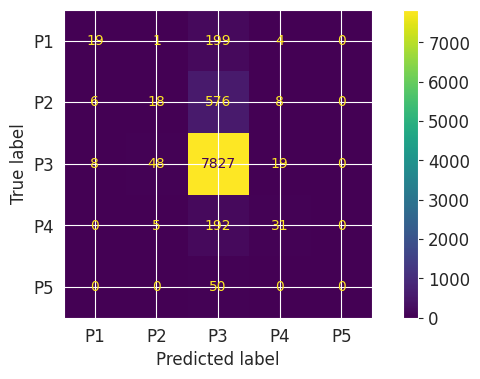

In [25]:
## Old code:

# plot_confusion_matrix(model1,X_test_tf,
#                       Y_test, values_format='d',
#                       cmap=plt.cm.Blues)
# plt.show()

## New code:

cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = model1.classes_)
disp.plot()
plt.show()

In [26]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

          P1       0.58      0.09      0.15       223
          P2       0.25      0.03      0.05       608
          P3       0.89      0.99      0.93      7902
          P4       0.50      0.14      0.21       228
          P5       0.00      0.00      0.00        50

    accuracy                           0.88      9011
   macro avg       0.44      0.25      0.27      9011
weighted avg       0.82      0.88      0.83      9011



### Class Imbalance


In [28]:
# Filter bug reports with priority P3 and sample 4000 rows from it
df_sampleP3 = df[df['Priority'] == 'P3'].sample(n=4000, random_state=123)

# Create a separate dataframe containing all other bug reports
df_sampleRest = df[df['Priority'] != 'P3']

# Concatenate the two dataframes to create the new balanced bug reports dataset
df_balanced = pd.concat([df_sampleRest, df_sampleP3])

# Check the status of the class imbalance
print(df_balanced['Priority'].value_counts())

Priority
P3    4000
P2    3038
P4    1138
P1    1117
P5     252
Name: count, dtype: int64


# Final Blueprint for Text Classification

In [30]:
# Loading the balanced dataframe

df = df_balanced[['text', 'Priority']]
df = df.dropna()

# Step 1 - Data Preparation

df['text'] = df['text'].apply(clean)

# Step 2 - Train-Test Split
X_train, X_test, \
Y_train, Y_test = train_test_split(df['text'], df['Priority'], test_size=0.2,
                                   random_state=42, stratify=df['Priority'])


print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

# Step 3 - Training the Machine Learning model

tfidf = TfidfVectorizer(min_df=10, ngram_range=(1, 2), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)

model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_tf, Y_train)

# Step 4 - Model Evaluation

X_test_tf = tfidf.transform(X_test)
Y_pred = model1.predict(X_test_tf)
print('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

Size of Training Data  7636
Size of Test Data  1909


LinearSVC(random_state=0, tol=1e-05)

Accuracy Score -  0.5028810895756941
              precision    recall  f1-score   support

          P1       0.44      0.29      0.35       223
          P2       0.45      0.48      0.46       608
          P3       0.56      0.66      0.60       800
          P4       0.47      0.34      0.39       228
          P5       0.00      0.00      0.00        50

    accuracy                           0.50      1909
   macro avg       0.38      0.35      0.36      1909
weighted avg       0.48      0.50      0.49      1909



In [31]:
clf = DummyClassifier(strategy='stratified', random_state=21)
clf.fit(X_train, Y_train)
Y_pred_baseline = clf.predict(X_test)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred_baseline))

DummyClassifier(random_state=21, strategy='stratified')

Accuracy Score -  0.31691985332634887


In [32]:
## Create a dataframe combining the Title and Description,
## Actual and Predicted values that we can explore
frame = { 'text': X_test, 'actual': Y_test, 'predicted': Y_pred }
result = pd.DataFrame(frame)

result[((result['actual'] == 'P1') | (result['actual'] == 'P2')) &
       (result['actual'] == result['predicted'])].sample(2, random_state=22)

,text,actual,predicted
8461,Variable view show old instance using build 20020917; ; Step to reproduce:; 1) create a selfhosting workspace (20020917).; 2) put a breakpoint in CompletionEngine at line 774 ; CompilationUnitDeclaration parsedUnit = parser.dietParse(...).; 3) create a launch configuration Runtime Workbench.; 4) launch this configuration in debugger.; 5) create a Java project.; 6) create a class.; 7) do ctrl+space in editor to hit breakpoint.; 8) look the id of the parser field of CompletionEngine in the variable view .; 9) step into parser.dietParse(...).; 10) in variable view the id of the parser is the same as step 8.; 11) do resume.; 12) do ctrl+space in editor to hit breakpoint.; 13) the id of the parser field is the same as step 8 (but it should not be the ; same instance of CompletionParser).; 14) step into parser.dietParse(...).; 15) the id of parser is a new id (as expected).; ; It seems that variable view doesnt show the right instance in the step 13.,P1,P1
34854,model proxy created for Java debug target in var view While investigating bug 177910; I found that the deltas for thread creation were duplicated in the output produced by Walter. I discovered that two model proxies are created for Java debug targets because the JavaModelProxyFactory does not limit the creation of proxies for targets to the debug view (as it should).,P2,P2


In [33]:
result[((result['actual'] == 'P1') | (result['actual'] == 'P2')) &
       (result['actual'] != result['predicted'])].sample(2, random_state=33)

,text,actual,predicted
40065,Too many semicolons after constructor completion I20090611-1540; ; public class Try {; Object m() {; return null;; }; }; ; select null; type new Runna; Ctrl+Space; press Enter to select the anonymous proposal for Runnable(); ; => Result:; ; public class Try {; Object m() {; return new Runnable() {; ; public void run() {; // TODO Auto-generated method stub; ; }; };;;; };,P2,P3
7178,Next/Previous buttons have double image 20020606 XP; ; 1) Open Java editor; Outline; Search view; 2) Click in editor; click in outline; click in search; 3) Note that the show previous/ show next buttons have a double image.; Hover over the button and the imgae is corrected,P2,P3


# Cross-Validation

In [34]:
# Vectorization

tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
df_tf = tfidf.fit_transform(df['text']).toarray()

# Cross Validation with 5 folds

scores = cross_val_score(estimator=model1, X=df_tf, y=df['Priority'], cv=5)

print ("Validation scores from each iteration of the cross validation ", scores)
print ("Mean value across of validation scores ", scores.mean())
print ("Standard deviation of validation scores ", scores.std())

Validation scores from each iteration of the cross validation  [0.48192771 0.45311682 0.43949712 0.42221058 0.37297014]
Mean value across of validation scores  0.43394447354635934
Standard deviation of validation scores  0.036211476115013436


# Hyperparameter Tuning with Grid Search

In [ ]:
training_pipeline = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words="english")),
    ('model', LinearSVC(random_state=21, tol=1e-5))
])

grid_param = [{
    'tfidf__min_df': [5, 10],
    'tfidf__ngram_range': [(1, 3), (1, 6)],
    'model__penalty': ['l2'],
    'model__loss': ['hinge'],
    'model__max_iter': [10000]
}, {
    'tfidf__min_df': [5, 10],
    'tfidf__ngram_range': [(1, 3), (1, 6)],
    'model__C': [1, 10],
    'model__tol': [1e-2, 1e-3]
}]

gridSearchProcessor = GridSearchCV(estimator=training_pipeline,
                                   param_grid=grid_param,
                                   cv=5)
gridSearchProcessor.fit(df['text'], df['Priority'])

best_params = gridSearchProcessor.best_params_
print("Best alpha parameter identified by grid search ", best_params)

best_result = gridSearchProcessor.best_score_
print("Best result identified by grid search ", best_result)

In [ ]:
gridsearch_results = pd.DataFrame(gridSearchProcessor.cv_results_)
gridsearch_results[['rank_test_score', 'mean_test_score',
                    'params']].sort_values(by=['rank_test_score'])[:5]

# Blueprint recap and conclusion


In [ ]:
# Flag that determines the choice of SVC (True) and LinearSVC (False)
runSVC = True

# Loading the dataframe

file = "eclipse_jdt.csv"
file = f"{BASE_DIR}/data/jdt-bugs-dataset/eclipse_jdt.csv.gz" ### real location
df = pd.read_csv(file)
df = df[['Title', 'Description', 'Component']]
df = df.dropna()
df['text'] = df['Title'] + df['Description']
df = df.drop(columns=['Title', 'Description'])

# Step 1 - Data Preparation
df['text'] = df['text'].apply(clean)
df = df[df['text'].str.len() > 50]

if (runSVC):
    # Sample the data when running SVC to ensure reasonable run-times
    df = df.groupby('Component', as_index=False).apply(pd.DataFrame.sample,
                                                       random_state=42,
                                                       frac=.2)

# Step 2 - Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(df['text'],
                                                    df['Component'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['Component'])
print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

# Step 3 - Training the Machine Learning model
tfidf = TfidfVectorizer(stop_words="english")

if (runSVC):
    model = SVC(random_state=42, probability=True)
    grid_param = [{
        'tfidf__min_df': [5, 10],
        'tfidf__ngram_range': [(1, 3), (1, 6)],
        'model__C': [1, 100],
        'model__kernel': ['linear']
    }]
else:
    model = LinearSVC(random_state=42, tol=1e-5)
    grid_param = {
        'tfidf__min_df': [5, 10],
        'tfidf__ngram_range': [(1, 3), (1, 6)],
        'model__C': [1, 100],
        'model__loss': ['hinge']
    }

training_pipeline = Pipeline(
    steps=[('tfidf', TfidfVectorizer(stop_words="english")), ('model', model)])

gridSearchProcessor = GridSearchCV(estimator=training_pipeline,
                                   param_grid=grid_param,
                                   cv=5)

gridSearchProcessor.fit(X_train, Y_train)

best_params = gridSearchProcessor.best_params_
print("Best alpha parameter identified by grid search ", best_params)

best_result = gridSearchProcessor.best_score_
print("Best result identified by grid search ", best_result)

best_model = gridSearchProcessor.best_estimator_

# Step 4 - Model Evaluation

Y_pred = best_model.predict(X_test)
print('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

Size of Training Data  7208
Size of Test Data  1802


In [ ]:
clf = DummyClassifier(strategy='most_frequent', random_state=21)
clf.fit(X_train, Y_train)
Y_pred_baseline = clf.predict(X_test)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred_baseline))

In [ ]:
## Create a dataframe combining the Title and Description,
## Actual and Predicted values that we can explore
frame = { 'text': X_test, 'actual': Y_test, 'predicted': Y_pred }
result = pd.DataFrame(frame)

result[result['actual'] == result['predicted']].sample(2, random_state=21)

In [ ]:
result[result['actual'] != result['predicted']].sample(2, random_state=42)

# Closing Remarks


# Further Reading
